In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as scio
import time
import os
from torch.nn.utils import weight_norm

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
torch.manual_seed(66)
np.random.seed(66)
torch.set_default_dtype(torch.float32)

In [17]:
bilapl_op = [[[[  0,   0,   0,   -1/6,     0,    0,    0],
             [    0,   0,   0,     2,      0,    0,    0],
             [    0,   0,   0,   -13/2,    0,    0,    0],
             [  -1/6,  2, -13/2,   56/3, -13/2,  2,  -1/6],
             [    0,   0,   0,    -13/2,   0,    0,    0],
             [    0,   0,   0,     2,      0,    0,    0],
             [    0,   0,   0,    -1/6,    0,    0,    0]]]]

lapl_op = [[[[    0,   0, -1/12,   0,     0],
             [    0,   0,   4/3,   0,     0],
             [-1/12, 4/3,    -5, 4/3, -1/12],
             [    0,   0,   4/3,   0,     0],
             [    0,   0, -1/12,   0,     0]]]]

partial_y = [[[[0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0],
               [1/12, -8/12, 0, 8/12, -1/12],
               [0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0]]]]

partial_x = [[[[0, 0, 1/12, 0, 0],
               [0, 0, -8/12, 0, 0],
               [0, 0, 0, 0, 0],
               [0, 0, 8/12, 0, 0],
               [0, 0, -1/12, 0, 0]]]]

In [5]:
def initialize_weights(module):

    if isinstance(module, nn.Conv2d):
        #nn.init.kaiming_normal_(module.weight.data, mode='fan_out')
        c = 1 
        module.weight.data.uniform_(-c*np.sqrt(1 / (3 * 3 * 320)), 
            c*np.sqrt(1 / (3 * 3 * 320)))
     
    elif isinstance(module, nn.Linear):
        module.bias.data.zero_()

In [6]:
class ConvLSTMCell(nn.Module):
    ''' Convolutional LSTM '''
    def __init__(self, input_channels, hidden_channels, input_kernel_size, 
        input_stride, input_padding):

        super(ConvLSTMCell, self).__init__()

        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.hidden_kernel_size = 3
        self.input_kernel_size = input_kernel_size  
        self.input_stride = input_stride
        self.input_padding = input_padding
        # self.num_features = 4

        # padding for hidden state
        self.padding = int((self.hidden_kernel_size - 1) / 2)

        self.Wxi = nn.Conv2d(self.input_channels, self.hidden_channels, 
            self.input_kernel_size, self.input_stride, self.input_padding, 
            bias=True, padding_mode='circular')

        self.Whi = nn.Conv2d(self.hidden_channels, self.hidden_channels, 
            self.hidden_kernel_size, 1, padding=1, bias=False, 
            padding_mode='circular')

        self.Wxf = nn.Conv2d(self.input_channels, self.hidden_channels, 
            self.input_kernel_size, self.input_stride, self.input_padding,
            bias=True, padding_mode='circular')

        self.Whf = nn.Conv2d(self.hidden_channels, self.hidden_channels, 
            self.hidden_kernel_size, 1, padding=1, bias=False, 
            padding_mode='circular')

        self.Wxc = nn.Conv2d(self.input_channels, self.hidden_channels, 
            self.input_kernel_size, self.input_stride, self.input_padding,
            bias=True, padding_mode='circular')

        self.Whc = nn.Conv2d(self.hidden_channels, self.hidden_channels, 
            self.hidden_kernel_size, 1, padding=1, bias=False, 
            padding_mode='circular')

        self.Wxo = nn.Conv2d(self.input_channels, self.hidden_channels, 
            self.input_kernel_size, self.input_stride, self.input_padding, 
            bias=True, padding_mode='circular')

        self.Who = nn.Conv2d(self.hidden_channels, self.hidden_channels, 
            self.hidden_kernel_size, 1, padding=1, bias=False, 
            padding_mode='circular')       

        nn.init.zeros_(self.Wxi.bias)
        nn.init.zeros_(self.Wxf.bias)
        nn.init.zeros_(self.Wxc.bias)
        self.Wxo.bias.data.fill_(1.0)

    def forward(self, x, h, c):

        ci = torch.sigmoid(self.Wxi(x) + self.Whi(h))
        cf = torch.sigmoid(self.Wxf(x) + self.Whf(h))
        cc = cf * c + ci * torch.tanh(self.Wxc(x) + self.Whc(h))
        co = torch.sigmoid(self.Wxo(x) + self.Who(h))
        ch = co * torch.tanh(cc)

        return ch, cc

    def init_hidden_tensor(self, prev_state):
        return (Variable(prev_state[0]).cuda(), Variable(prev_state[1]).cuda())


In [7]:
class encoder_block(nn.Module):
    ''' encoder with CNN '''
    def __init__(self, input_channels, hidden_channels, input_kernel_size, 
        input_stride, input_padding):
        
        super(encoder_block, self).__init__()

        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.input_kernel_size = input_kernel_size  
        self.input_stride = input_stride
        self.input_padding = input_padding

        self.conv = weight_norm(nn.Conv2d(self.input_channels, 
            self.hidden_channels, self.input_kernel_size, self.input_stride, 
            self.input_padding, bias=True, padding_mode='circular'))

        self.act = nn.ReLU()

        nn.init.zeros_(self.conv.bias)

    def forward(self, x):
        return self.act(self.conv(x))

In [8]:
class PhyCRNet(nn.Module):
    ''' physics-informed convolutional-recurrent neural networks '''
    def __init__(self, input_channels, hidden_channels, 
        input_kernel_size, input_stride, input_padding, dt, 
        num_layers, upscale_factor, step=1, effective_step=[1]):

        super(PhyCRNet, self).__init__()

        # input channels of layer includes input_channels and hidden_channels of cells 
        self.input_channels = [input_channels] + hidden_channels
        self.hidden_channels = hidden_channels
        self.input_kernel_size = input_kernel_size
        self.input_stride = input_stride
        self.input_padding = input_padding
        self.step = step
        self.effective_step = effective_step
        self._all_layers = []
        self.dt = dt
        self.upscale_factor = upscale_factor

        # number of layers
        self.num_encoder = num_layers[0]
        self.num_convlstm = num_layers[1]

        # encoder - downsampling  
        for i in range(self.num_encoder):
            name = 'encoder{}'.format(i)
            cell = encoder_block(
                input_channels = self.input_channels[i], 
                hidden_channels = self.hidden_channels[i], 
                input_kernel_size = self.input_kernel_size[i],
                input_stride = self.input_stride[i],
                input_padding = self.input_padding[i])

            setattr(self, name, cell)
            self._all_layers.append(cell)            
            
        # ConvLSTM
        for i in range(self.num_encoder, self.num_encoder + self.num_convlstm):
            name = 'convlstm{}'.format(i)
            cell = ConvLSTMCell(
                input_channels = self.input_channels[i],
                hidden_channels = self.hidden_channels[i],
                input_kernel_size = self.input_kernel_size[i],
                input_stride = self.input_stride[i],
                input_padding = self.input_padding[i])
        
            setattr(self, name, cell)
            self._all_layers.append(cell)  

        # output layer
        self.output_layer = nn.Conv2d(2, 2, kernel_size = 5, stride = 1, 
                                      padding=2, padding_mode='circular')

        # pixelshuffle - upscale
        self.pixelshuffle = nn.PixelShuffle(self.upscale_factor)   

        # initialize weights
        self.apply(initialize_weights)
        nn.init.zeros_(self.output_layer.bias)

    def forward(self, initial_state, x): #(1x128x16x16, 1x2x128x128)
        
        self.initial_state = initial_state
        internal_state = []
        outputs = []
        second_last_state = []

        for step in range(self.step):
            xt = x

            # encoder
            for i in range(self.num_encoder):
                name = 'encoder{}'.format(i)
                x = getattr(self, name)(x) 
                #(1x128x16x16)
                
            # convlstm
            for i in range(self.num_encoder, self.num_encoder + self.num_convlstm):
                name = 'convlstm{}'.format(i)
                if step == 0:
                    (h, c) = getattr(self, name).init_hidden_tensor(
                        prev_state = self.initial_state[i - self.num_encoder])  
                    internal_state.append((h,c)) #(1x128x16x16)
                
                # one-step forward
                (h, c) = internal_state[i - self.num_encoder]
                x, new_c = getattr(self, name)(x, h, c) #(1x128x16x16)
                internal_state[i - self.num_encoder] = (x, new_c)                               

            # output
            x = self.pixelshuffle(x)
            #(1x2x128x128)
            x = self.output_layer(x)
            #(1x2x128x128)

            # residual connection
            x = xt + self.dt * x

            if step == (self.step - 2):
                second_last_state = internal_state.copy()
                
            if step in self.effective_step:
                outputs.append(x)                

        return outputs, second_last_state #(1001x2x128x128) #(1x128x16x16)

In [9]:
class Conv2dDerivative(nn.Module):
    def __init__(self, DerFilter, resol, kernel_size=3, name=''):
        super(Conv2dDerivative, self).__init__()

        self.resol = resol  # constant in the finite difference
        self.name = name
        self.input_channels = 1
        self.output_channels = 1
        self.kernel_size = kernel_size

        # self.padding = int((kernel_size - 1) / 2)
        self.filter = nn.Conv2d(self.input_channels, self.output_channels, self.kernel_size, 
            1, padding=0, bias=False)

        # Fixed gradient operator
        self.filter.weight = nn.Parameter(torch.FloatTensor(DerFilter), requires_grad=False)  

    def forward(self, input):
        derivative = self.filter(input)
        return derivative / self.resol


In [10]:
class Conv1dDerivative(nn.Module):
    def __init__(self, DerFilter, resol, kernel_size=3, name=''):
        super(Conv1dDerivative, self).__init__()

        self.resol = resol  # $\delta$*constant in the finite difference
        self.name = name
        self.input_channels = 1
        self.output_channels = 1
        self.kernel_size = kernel_size

        self.padding = int((kernel_size - 1) / 2)
        self.filter = nn.Conv1d(self.input_channels, self.output_channels, self.kernel_size, 
            1, padding=0, bias=False)
        
        # Fixed gradient operator
        self.filter.weight = nn.Parameter(torch.FloatTensor(DerFilter), requires_grad=False)  

    def forward(self, input):
        derivative = self.filter(input)
        return derivative / self.resol

In [11]:
class loss_generator(nn.Module):
    ''' Loss generator for physics loss '''

    def __init__(self, dt = (10.0/200), dx = (20.0/128)):
        ''' Construct the derivatives, X = Width, Y = Height '''
       
        super(loss_generator, self).__init__()

        # spatial derivative operator
        self.bilaplace = Conv2dDerivative(
            DerFilter = bilapl_op,
            resol = (dx**4),
            kernel_size = 7,
            name = 'bilaplace_operator').cuda()

        
        self.laplace = Conv2dDerivative(
            DerFilter = lapl_op,
            resol = (dx**2),
            kernel_size = 5,
            name = 'laplace_operator').cuda()

        self.dx = Conv2dDerivative(
            DerFilter = partial_x,
            resol = (dx*1),
            kernel_size = 5,
            name = 'dx_operator').cuda()

        self.dy = Conv2dDerivative(
            DerFilter = partial_y,
            resol = (dx*1),
            kernel_size = 5,
            name = 'dy_operator').cuda()

        # temporal derivative operator
        self.dt = Conv1dDerivative(
            DerFilter = [[[-1, 0, 1]]],
            resol = (dt*2),
            kernel_size = 3,
            name = 'partial_t').cuda()

    def get_phy_Loss(self, output):

        # spatial derivatives
        #output (1002x2x133x133)
        # print(output.shape)
        laplace_u = self.laplace(output[1:-1, 0:1, 1:-1, 1:-1])  # [t,c,h,w]
        #(1000x2x128x128)
        laplace_v = self.laplace(output[1:-1, 1:2, 1:-1, 1:-1])
        #(1000x2x128x128)
        # print(laplace_u.shape)
        
        bilaplace_u = self.bilaplace(output[1:-1, 0:1, :, :])
        bilaplace_v = self.bilaplace(output[1:-1, 1:2, :, :]) 

        u_x = self.dx(output[1:-1, 0:1, 1:-1, 1:-1])
        #(1000x2x128x128)
        u_y = self.dy(output[1:-1, 0:1, 1:-1, 1:-1])
        #(1000x2x128x128)
        v_x = self.dx(output[1:-1, 1:2, 1:-1, 1:-1])
        #(1000x2x128x128)
        v_y = self.dy(output[1:-1, 1:2, 1:-1, 1:-1])
        #(1000x2x128x128)

        # temporal derivative - u

        u = output[:, 0:1, 3:-3, 3:-3]
        #(1002x1x129x129)
        lent = u.shape[0]
        lenx = u.shape[3]
        leny = u.shape[2]
        u_conv1d = u.permute(2, 3, 1, 0)  # [height(Y), width(X), c, step]
        u_conv1d = u_conv1d.reshape(lenx*leny,1,lent)
        #(129*129x1x1002)
        u_t = self.dt(u_conv1d)  # lent-2 due to no-padding
        #(129*129x1x1000)
        u_t = u_t.reshape(leny, lenx, 1, lent-2)
        #(129x129x1x1000)
        u_t = u_t.permute(3, 2, 0, 1)  # [step-2, c, height(Y), width(X)]
        #(1000x1x129x129)

        # temporal derivative - v
        v = output[:, 1:2, 3:-3, 3:-3]
        v_conv1d = v.permute(2, 3, 1, 0)  # [height(Y), width(X), c, step]
        v_conv1d = v_conv1d.reshape(lenx*leny,1,lent)
        v_t = self.dt(v_conv1d)  # lent-2 due to no-padding
        v_t = v_t.reshape(leny, lenx, 1, lent-2)
        v_t = v_t.permute(3, 2, 0, 1)  # [step-2, c, height(Y), width(X)]

        u = output[1:-1, 0:1, 3:-3, 3:-3]  # [t, c, height(Y), width(X)]
        v = output[1:-1, 1:2, 3:-3, 3:-3]  # [t, c, height(Y), width(X)]
        # print(laplace_u.shape)


        assert laplace_u.shape == u_t.shape
        assert u_t.shape == v_t.shape
        assert laplace_u.shape == u.shape
        assert laplace_v.shape == v.shape

        R = 200.0

        # 2D Bansal's equations
        f_u = u_t - laplace_u + 0.5 * u + u**3 - 1.5 * u * v
        f_v = v_t + bilaplace_v + 2 * laplace_v + 1.5 * v  + v**3 - 0.75 * u**2
        # print(u_t.shape)
        # print(laplace_u.shape)
        # print(u.shape)

        return f_u, f_v


In [12]:
def compute_loss(output, loss_func):
    ''' calculate the physics loss '''
    
    # Padding x axis due to periodic boundary condition
    # shape: [t, c, h, w]
    output = torch.cat((output[:, :, :, -3:], output, output[:, :, :, 0:4]), dim=3) #(1002x2x135x128)

    # Padding y axis due to periodic boundary condition
    # shape: [t, c, h, w]
    output = torch.cat((output[:, :, -3:, :], output, output[:, :, 0:4, :]), dim=2) #(1002x2x135x135)

    # get physics loss
    mse_loss = nn.MSELoss()
    f_u, f_v = loss_func.get_phy_Loss(output) #(1000x1x129x129)x2
    loss =  mse_loss(f_u, torch.zeros_like(f_u).cuda()) + mse_loss(f_v, torch.zeros_like(f_v).cuda()) 

    return loss

In [13]:
def train(model, input, initial_state, n_iters, time_batch_size, learning_rate, 
          dt, dx, save_path, pre_model_save_path, num_time_batch):

    train_loss_list = []
    second_last_state = []
    prev_output = []

    batch_loss = 0.0
    best_loss = 1e4

    # load previous model
    optimizer = optim.Adam(model.parameters(), lr=learning_rate) 
    scheduler = StepLR(optimizer, step_size=100, gamma=0.97)  
    # model, optimizer, scheduler = load_checkpoint(model, optimizer, scheduler, 
    #     pre_model_save_path)

    for param_group in optimizer.param_groups:
        print(param_group['lr'])

    loss_func = loss_generator(dt, dx)
        
    for epoch in range(n_iters):
        # input: [t,b,c,h,w]
        optimizer.zero_grad()
        batch_loss = 0 
        
        for time_batch_id in range(num_time_batch):
            # update the first input for each time batch
            if time_batch_id == 0:
                hidden_state = initial_state #(1, 128, 16, 16)x2
                u0 = input #(1, 2, 128, 128)
            else:
                hidden_state = state_detached
                u0 = prev_output[-2:-1].detach() # second last output

            # output is a list
            output, second_last_state = model(hidden_state, u0) #(1001x2x128x128) #(1x128x16x16)

            # [t, c, height (Y), width (X)]
            output = torch.cat(tuple(output), dim=0) #(1001x2x128x128) 

            # concatenate the initial state to the output for central diff
            output = torch.cat((u0.cuda(), output), dim=0) #(1+1001x2x128x128)

            # get loss
            loss = compute_loss(output, loss_func)
            loss.backward(retain_graph=True)
            batch_loss += loss.item()

            # update the state and output for next batch
            prev_output = output
            state_detached = []
            for i in range(len(second_last_state)):
                (h, c) = second_last_state[i]
                state_detached.append((h.detach(), c.detach())) # hidden state

        optimizer.step()
        scheduler.step()

        # print loss in each epoch
        print('[%d/%d %d%%] loss: %.10f' % ((epoch+1), n_iters, ((epoch+1)/n_iters*100.0), 
            batch_loss))
        train_loss_list.append(batch_loss)

        # save model
        # if batch_loss < best_loss:
        #     save_checkpoint(model, optimizer, scheduler, save_path)
        #     best_loss = batch_loss
    
    return train_loss_list

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [15]:
def post_process(output, true, axis_lim, uv_lim, num, fig_save_path):
    ''' 
    axis_lim: [xmin, xmax, ymin, ymax]
    uv_lim: [u_min, u_max, v_min, v_max]
    num: Number of time step
    '''

    # get the limit 
    xmin, xmax, ymin, ymax = axis_lim
    u_min, u_max, v_min, v_max = uv_lim

    # grid
    x = np.linspace(xmin, xmax, 128+1)
    x = x[:-1]
    x_star, y_star = np.meshgrid(x, x)
    
    u_star = true[num, 0, 1:-1, 1:-1]
    u_pred = output[num, 0, 1:-1, 1:-1].detach().cpu().numpy()

    v_star = true[num, 1, 1:-1, 1:-1]
    v_pred = output[num, 1, 1:-1, 1:-1].detach().cpu().numpy()

    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(7, 7))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    cf = ax[0, 0].scatter(x_star, y_star, c=u_pred, alpha=0.9, edgecolors='none', 
        cmap='RdYlBu', marker='s', s=4, vmin=u_min, vmax=u_max)
    ax[0, 0].axis('square')
    ax[0, 0].set_xlim([xmin, xmax])
    ax[0, 0].set_ylim([ymin, ymax])
    ax[0, 0].set_title('u-RCNN')
    fig.colorbar(cf, ax=ax[0, 0])

    cf = ax[0, 1].scatter(x_star, y_star, c=u_star, alpha=0.9, edgecolors='none', 
        cmap='RdYlBu', marker='s', s=4, vmin=u_min, vmax=u_max)
    ax[0, 1].axis('square')
    ax[0, 1].set_xlim([xmin, xmax])
    ax[0, 1].set_ylim([ymin, ymax])
    ax[0, 1].set_title('u-Ref.')
    fig.colorbar(cf, ax=ax[0, 1])

    cf = ax[1, 0].scatter(x_star, y_star, c=v_pred, alpha=0.9, edgecolors='none', 
        cmap='RdYlBu', marker='s', s=4, vmin=v_min, vmax=v_max)
    ax[1, 0].axis('square')
    ax[1, 0].set_xlim([xmin, xmax])
    ax[1, 0].set_ylim([ymin, ymax])
    cf.cmap.set_under('whitesmoke')
    cf.cmap.set_over('black')
    ax[1, 0].set_title('v-RCNN')
    fig.colorbar(cf, ax=ax[1, 0])

    cf = ax[1, 1].scatter(x_star, y_star, c=v_star, alpha=0.9, edgecolors='none', 
        cmap='RdYlBu', marker='s', s=4, vmin=v_min, vmax=v_max)
    ax[1, 1].axis('square')
    ax[1, 1].set_xlim([xmin, xmax])
    ax[1, 1].set_ylim([ymin, ymax])
    cf.cmap.set_under('whitesmoke')
    cf.cmap.set_over('black')
    ax[1, 1].set_title('v-Ref.')
    fig.colorbar(cf, ax=ax[1, 1])

    # plt.draw()
    plt.savefig(fig_save_path + 'uv_comparison_'+str(num).zfill(3)+'.png')
    plt.close('all')

    return u_star, u_pred, v_star, v_pred


def save_checkpoint(model, optimizer, scheduler, save_dir):
    '''save model and optimizer'''

    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict()
        }, save_dir)


def load_checkpoint(model, optimizer, scheduler, save_dir):
    '''load model and optimizer'''
    
    checkpoint = torch.load(save_dir)
    model.load_state_dict(checkpoint['model_state_dict'])

    if (not optimizer is None):
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

    print('Pretrained model loaded!')

    return model, optimizer, scheduler


def summary_parameters(model):
    for i in model.parameters():
        print(i.shape)


def frobenius_norm(tensor):
    return np.sqrt(np.sum(tensor ** 2))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


0.0001
[1/100 1%] loss: 37818674405634473984.0000000000
[2/100 2%] loss: 37798861206101950464.0000000000
[3/100 3%] loss: 37778207979685806080.0000000000
[4/100 4%] loss: 37755795534665220096.0000000000
[5/100 5%] loss: 37730546349644972032.0000000000
[6/100 6%] loss: 37701343320811241472.0000000000
[7/100 7%] loss: 37666616345559564288.0000000000
[8/100 8%] loss: 37623981682680922112.0000000000
[9/100 9%] loss: 37569951681292009472.0000000000
[10/100 10%] loss: 37498716521951657984.0000000000
[11/100 11%] loss: 37399219515730952192.0000000000
[12/100 12%] loss: 37250499572957970432.0000000000
[13/100 13%] loss: 37016132072427749376.0000000000
[14/100 14%] loss: 36760972807016284160.0000000000
[15/100 15%] loss: 36667320804608835584.0000000000
[16/100 16%] loss: 36636754381356662784.0000000000
[17/100 17%] loss: 36594423183687286784.0000000000
[18/100 18%] loss: 36536267814670958592.0000000000
[19/100 19%] loss: 36469019484492922880.0000000000
[20/100 20%] loss: 36397793121245593600.00

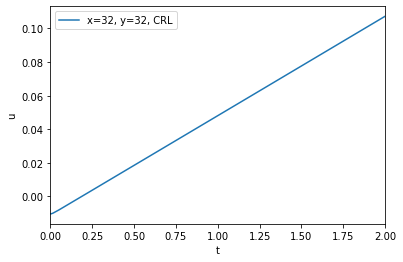

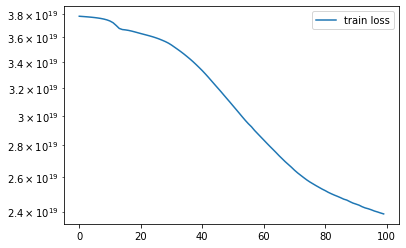

In [18]:
if __name__ == '__main__':

    ######### download the ground truth data ############
    a0 = 32
    uv0 = torch.randn(1, 2, a0, a0)
    input = torch.tensor(uv0, dtype=torch.float32).cuda() 

    # set initial states for convlstm
    num_convlstm = 1
    (h0, c0) = (torch.randn(1, 128, 4, 4), torch.randn(1, 128, 4, 4))
    initial_state = []
    for i in range(num_convlstm):
        initial_state.append((h0, c0))
    
    # grid parameters
    time_steps = 1001
    dt = 0.002
    dx = 1.0 / 128

    ################# build the model #####################
    time_batch_size = 1000
    steps = time_batch_size + 1
    effective_step = list(range(0, steps))
    num_time_batch = int(time_steps / time_batch_size)
    n_iters_adam = 100
    lr_adam = 1e-4 #1e-3 
    pre_model_save_path = './model/checkpoint500.pt'
    model_save_path = './model/checkpoint1000.pt'
    fig_save_path = './figures/'  

    model = PhyCRNet(
        input_channels = 2, 
        hidden_channels = [8, 32, 128, 128], 
        input_kernel_size = [4, 4, 4, 3], 
        input_stride = [2, 2, 2, 1], 
        input_padding = [1, 1, 1, 1],  
        dt = dt,
        num_layers = [3, 1],
        upscale_factor = 8,
        step = steps, 
        effective_step = effective_step).cuda()

    start = time.time()
    train_loss = train(model, input, initial_state, n_iters_adam, time_batch_size, 
        lr_adam, dt, dx, model_save_path, pre_model_save_path, num_time_batch)
    end = time.time()
    
    # np.save('./model/train_loss', train_loss)  
    print('The training time is: ', (end-start))

    ########### model inference ##################
    time_batch_size_load = 1000
    steps_load = time_batch_size_load + 1
    num_time_batch = int(time_steps / time_batch_size_load)
    effective_step = list(range(0, steps_load))  
    
    # model = PhyCRNet(
    #     input_channels = 2, 
    #     hidden_channels = [8, 32, 128, 128], 
    #     input_kernel_size = [4, 4, 4, 3], 
    #     input_stride = [2, 2, 2, 1], 
    #     input_padding = [1, 1, 1, 1],  
    #     dt = dt,
    #     num_layers = [3, 1],
    #     upscale_factor = 8,
    #     step = steps_load, 
    #     effective_step = effective_step).cuda()

    # model, _, _ = load_checkpoint(model, optimizer=None, scheduler=None, save_dir=model_save_path) 
    output, _ = model(initial_state, input)

    # shape: [t, c, h, w] 
    output = torch.cat(tuple(output), dim=0)  
    output = torch.cat((input.cuda(), output), dim=0) #(1002x2x128x128)
  
    # Padding x and y axis due to periodic boundary condition
    output = torch.cat((output[:, :, :, -1:], output, output[:, :, :, 0:2]), dim=3)
    output = torch.cat((output[:, :, -1:, :], output, output[:, :, 0:2, :]), dim=2)
    #(1002x2x133x133)

    # [t, c, h, w]
    # truth = uv[0:1001,:,:,:]

    # # [101, 2, 131, 131]
    # truth = np.concatenate((truth[:, :, :, -1:], truth, truth[:, :, :, 0:2]), axis=3)
    # truth = np.concatenate((truth[:, :, -1:, :], truth, truth[:, :, 0:2, :]), axis=2)

    # # post-process
    # ten_true = []
    # ten_pred = []
    # for i in range(0, 50): 
    #     u_star, u_pred, v_star, v_pred = post_process(output, truth, [0,1,0,1], 
    #         [-0.7,0.7,-1.0,1.0], num=20*i, fig_save_path=fig_save_path)

    #     ten_true.append([u_star, v_star])
    #     ten_pred.append([u_pred, v_pred])

    # # compute the error
    # error = frobenius_norm(np.array(ten_pred)-np.array(ten_true)) / frobenius_norm(
    #     np.array(ten_true))

    # print('The predicted error is: ', error)

    u_pred = output[:-1, 0, :, :].detach().cpu().numpy() #(1001x1x128x128)
    u_pred = np.swapaxes(u_pred, 1, 2) # [h,w] = [y,x]
    # u_true = truth[:, 0, :, :]

    t_true = np.linspace(0, 2, 1001)
    t_pred = np.linspace(0, 2, time_steps)

    plt.plot(t_pred, u_pred[:, 32, 32], label='x=32, y=32, CRL')
    # plt.plot(t_true, u_true[:, 32, 32], '--', label='x=32, y=32, Ref.')
    plt.xlabel('t')
    plt.ylabel('u')
    plt.xlim(0, 2)
    plt.legend()
    # plt.savefig(fig_save_path + "x=32,y=32.png")
    # plt.close("all")
    plt.show()

    # plot train loss
    plt.figure()
    plt.plot(train_loss, label = 'train loss')
    plt.yscale('log')
    plt.legend()
    # plt.savefig(fig_save_path + 'train loss.png', dpi = 300)

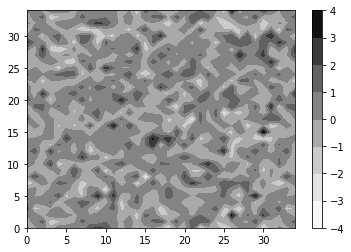

In [19]:
a2 = output[-1, 0, :, :].cpu().detach().numpy()
plt.contourf(a2, cmap = 'Greys')
plt.colorbar()
plt.show()

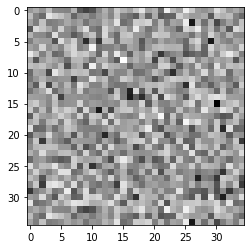

In [20]:
import matplotlib.animation as animation
fig, ax = plt.subplots()
ims = []
for i in range(1000):
  phi_ = output[i, 0, :, :]
  im = ax.imshow(phi_.cpu().detach().numpy(), cmap='Greys',  interpolation='nearest', animated = True)
  if i == 0:
      ax.imshow(phi_.cpu().detach().numpy(), cmap='Greys',  interpolation='nearest')
  ims.append([im])
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
writergif = animation.PillowWriter(fps=2) 
ani.save('animation.gif', writer=writergif)